In [1]:
%config IPCompleter.use_jedi = False

In [2]:
import os
import json
import numpy as np
import requests
import time
import cv2
import base64
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import display, HTML
from k12libs.utils.nb_easy import RACEURL

In [3]:
display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

In [4]:
API_INFERENCE = f'{RACEURL}/raceai/framework/inference'
API_INFERENCE

'http://116.85.5.40:9119/raceai/framework/inference'

In [5]:
API_POPMSG = f'{RACEURL}/raceai/private/popmsg'
API_POPMSG 

'http://116.85.5.40:9119/raceai/private/popmsg'

In [8]:
MODEL_TASK = 'zmq.ccpd2019.inference'
MSGKEY = 'zmq.ccpd2019.test'
CONF_THRES = 0.25
IOU_THRES = 0.45
IMG_ROOT = '/raceai/data/datasets/CCPD2019'

In [24]:
LABEL_NAMES = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 
    'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 
    'Y', 'Z', 'zh_cuan', 'zh_e', 'zh_gan', 'zh_gan1', 'zh_gui', 
    'zh_gui1', 'zh_hei', 'zh_hu', 'zh_ji', 'zh_jin', 'zh_jing', 
    'zh_jl', 'zh_liao', 'zh_lu', 'zh_meng', 'zh_min', 'zh_ning', 
    'zh_qing', 'zh_qiong', 'zh_shan', 'zh_su', 'zh_sx', 'zh_wan',
    'zh_xiang', 'zh_xin', 'zh_yu', 'zh_yu1', 'zh_yue', 'zh_yun', 
    'zh_zang', 'zh_zhe'
]
SAMPLE_FILES = [
    'images/val/0534231321839-93_72-120&497_561&632-569&637_150&604_114&500_533&533-0_0_13_27_25_32_12-81-167.jpg'
]

zh_provinces = {
    'zh_cuan': '川', 'zh_e': '鄂', 'zh_gan': '赣', 'zh_gan1': '甘',
    'zh_gui': '贵', 'zh_gui1': '桂', 'zh_hei': '黑', 'zh_hu': '沪',
    'zh_ji': '冀', 'zh_jin': '津', 'zh_jing': '京', 'zh_jl': '吉',
    'zh_liao': '辽', 'zh_lu': '鲁', 'zh_meng': '蒙', 'zh_min': '闽',
    'zh_ning': '宁', 'zh_qing': '青', 'zh_qiong': '琼', 'zh_shan': '陕',
    'zh_su': '苏',  'zh_sx': '晋', 'zh_wan': '皖', 'zh_xiang': '湘',
    'zh_xin': '新', 'zh_yu': '豫', 'zh_yu1': '渝', 'zh_yue': '粤',
    'zh_yun': '云', 'zh_zang': '藏', 'zh_zhe': '浙'
}

CN_LABEL_NAMES = [zh_provinces[x] if x[:2] == 'zh' else x for x in LABEL_NAMES]

## 调试

In [9]:
rawdata = '''{
    "task": "%s",
    "cfg": {
        "pigeon": {
            "msgkey": "%s",
            "user": "1",
            "uuid": "100"
        },
        "data": {
            "class_name": "raceai.data.process.PathListDataLoader",
            "params": {
                "data_source": %s,
                "dataset": {
                    "class_name": "raceai.data.RawRaceDataset",
                    "params": {
                        "data_prefix": "%s"
                    }
                }
            }
        },
        "nms":{
            "conf_thres": %.2f,
            "iou_thres": %.2f
        }
    }
}'''
rawdata_conf = rawdata % (MODEL_TASK, MSGKEY, SAMPLE_FILES, IMG_ROOT, CONF_THRES, IOU_THRES)

### 输入

In [10]:
print(rawdata_conf)

{
    "task": "zmq.ccpd2019.inference",
    "cfg": {
        "pigeon": {
            "msgkey": "zmq.ccpd2019.test",
            "user": "1",
            "uuid": "100"
        },
        "data": {
            "class_name": "raceai.data.process.PathListDataLoader",
            "params": {
                "data_source": ['images/val/0534231321839-93_72-120&497_561&632-569&637_150&604_114&500_533&533-0_0_13_27_25_32_12-81-167.jpg'],
                "dataset": {
                    "class_name": "raceai.data.RawRaceDataset",
                    "params": {
                        "data_prefix": "/raceai/data/datasets/CCPD2019"
                    }
                }
            }
        },
        "nms":{
            "conf_thres": 0.25,
            "iou_thres": 0.45
        }
    }
}


In [17]:
reqdata = eval(rawdata_conf)
json.loads(requests.get(url=f'{API_POPMSG}?key={MSGKEY}').text)
json.loads(requests.post(url=API_INFERENCE, json=reqdata).text)
time.sleep(3)
resdata = json.loads(requests.get(url=f'{API_POPMSG}?key={MSGKEY}').text)
resdata

[{'pigeon': {'msgkey': 'zmq.ccpd2019.test', 'user': '1', 'uuid': '100'},
  'task': 'zmq.ccpd2019.inference',
  'errno': 0,
  'result': [[39, 10, 23, 45, 28, 8, 22]],
  'running_time': 0.059}]

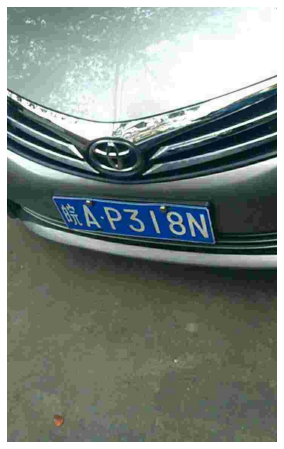

In [23]:
test_image = cv2.imread(f'{IMG_ROOT}/{SAMPLE_FILES[0]}')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(test_image)
plt.axis(False);

In [28]:
for jdata in resdata:
    if 'result' in jdata:
        for lpids in jdata['result']:
            print('*'*40)
            for lp in lpids:
                print(CN_LABEL_NAMES[lp], end=' ')
            print('')
            print('*'*40)

****************************************
桂 A P 吉 U 8 N 
****************************************
